<a href="https://colab.research.google.com/github/HelmyPurnomoHidayat22/analisis-data-dengan-python/blob/main/naivebayes_cekbansos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [94]:
!pip install emoji

In [95]:
# 1. IMPORT LIBRARY

import pandas as pd
import numpy as np
import re
from collections import defaultdict
import nltk
nltk.download('punkt')


# Sklearn
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score
)

# NLP
import nltk
nltk.download('punkt')
from nltk.probability import FreqDist
from nltk.tokenize import word_tokenize
import emoji

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
from wordcloud import WordCloud
# Ignore warnings
import warnings
warnings.filterwarnings('ignore')
print("Library berhasil di-import")

Library berhasil di-import


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [96]:
path = "/content/A_6.xlsx"
df = pd.read_excel(path)

df.columns = ['review_text', 'rating']

print("\n=== INFO DATASET ===")
print(f"Shape: {data.shape}")
print("\nContoh Data:")
print(data.head(10))
print("\nMissing Values:")
print(data.isnull().sum())



=== INFO DATASET ===
Shape: (45956, 2)

Contoh Data:
                                         review_text  rating
0                                        sangat baik       5
1                                         app bodonk       1
2                                   aplikasi ga niat       1
3  kenapa setiap kali klik masuk cek bansos sll t...       1
4                                         mantap gan       5
5        sangat baik dan bagus pingin daftar Bansos.       5
6                                                 Ok       5
7                                    Aplikasi setres       1
8  gak bisa daftar,, udah cape2 isi data, pas fot...       1
9  ni aplikasi blt bukan di permudah daptar malah...       1

Missing Values:
review_text    0
rating         0
dtype: int64


In [97]:
print("DATA CLEANING - TAHAP 1 ")

try:
    import emoji
    def demojize(text):
        return emoji.demojize(text)
    print("emoji package tersedia -> menggunakan emoji.demojize")
except Exception:
    import re
    emoji_pattern = re.compile(
        "["
        "\U0001F600-\U0001F64F"
        "\U0001F300-\U0001F5FF"
        "\U0001F680-\U0001F6FF"
        "\U0001F1E0-\U0001F1FF"
        "\U00002700-\U000027BF"
        "\U0001F900-\U0001F9FF"
        "\U00002600-\U000026FF"
        "]+", flags=re.UNICODE)
    def demojize(text):
        if not isinstance(text, str):
            text = str(text)
        text = re.sub(r':[A-Za-z0-9_\-\+]+:', ' ', text)
        return emoji_pattern.sub(' ', text)
    print("emoji package TIDAK tersedia -> menggunakan fallback demojize")

# --- PERBAIKAN KECIL 2: pastikan variabel df ada (jika Anda sebelumnya memakai 'data') ---
try:
    df
except NameError:
    try:
        df = data.copy()
        print("Variabel 'data' ditemukan -> disalin ke 'df'.")
    except NameError:
        raise NameError("Variabel 'df' atau 'data' tidak ditemukan. Jalankan cell yang membaca file Excel dulu.")

# Jika 'category' belum ada, buat berdasarkan asumsi rating==5 -> positive, else negative
if 'category' not in df.columns:
    df['category'] = df['rating'].apply(lambda x: 'positive' if x == 5 else 'negative')

# Daftar karakter untuk cleaning (tetap seperti struktur Anda)
character = ['.', ',', ';', ':', '-', '...', '..', '?', '!', '(', ')', '[', ']',
             '{', '}', '<', '>', '"', '/', "'", '#', '@'] + \
            list('abcdefghijklmnopqrstuvwxyz') + list('ABCDEFGHIJKLMNOPQRSTUVWXYZ')

# Fungsi hapus karakter berulang (sama struktur)
def repeatcharClean(text):
    for ch in character:
        charac_long = 5
        while charac_long > 2:
            char = ch * charac_long
            text = text.replace(char, ch)
            charac_long -= 1
    return text

# PERBAIKAN: gunakan demojize() bukan emoji.demojize() agar fallback bekerja
def clean_review(text):
    text = str(text)
    text = text.lower()
    text = re.sub(r'\n', ' ', text)
    text = demojize(text)                        # kecil perubahan di sini
    text = re.sub(r':[a-z0-9_\-\+]+:', ' ', text)
    text = re.sub(r"([xX;:]'?[dDpPvVoO3)(])", ' ', text)
    text = re.sub(r"(https?:\/\/\S+|www\.\S+)", "", text)
    text = re.sub(r"@[^\s]+[\s]?", ' ', text)
    text = re.sub(r'#(\S+)', r'\1', text)
    text = re.sub('[^a-zA-Z\s]', ' ', text)
    text = repeatcharClean(text)
    text = re.sub('[ ]+', ' ', text)
    return text.strip()

# Terapkan preprocessing tahap 1 (sama struktur)
df_v1 = df.copy()
df_v1['review_text'] = df_v1['review_text'].apply(clean_review)

# Hapus baris kosong
df_v1['review_text'].replace('', np.nan, inplace=True)
df_v1['review_text'].replace(' ', np.nan, inplace=True)
df_v1.dropna(subset=['review_text'], inplace=True)

print(f"Jumlah data setelah cleaning tahap 1: {len(df_v1)}")
print(f"\nContoh hasil cleaning tahap 1:")

# PERBAIKAN: sekarang aman memanggil kolom 'category' karena sudah dibuat di atas (jika belum ada)
print(df_v1[['review_text', 'category']].head())

# Export hasil preprocessing tahap 1 (tetap sama)
df_v1.to_csv('df_v1_nb.csv', sep=',', index=False)
print("File df_v1_nb.csv berhasil disimpan")


DATA CLEANING - TAHAP 1 
emoji package tersedia -> menggunakan emoji.demojize
Jumlah data setelah cleaning tahap 1: 45767

Contoh hasil cleaning tahap 1:
                                         review_text  category
0                                        sangat baik  positive
1                                         app bodonk  negative
2                                   aplikasi ga niat  negative
3  kenapa setiap kali klik masuk cek bansos sll t...  negative
4                                         mantap gan  positive
File df_v1_nb.csv berhasil disimpan


In [98]:
# LOAD STOPWORDS
print("\n=== LOAD STOPWORDS ===")

stopword_file = "/content/stopwords.txt"
with open(stopword_file, 'r', encoding='utf-8') as f:
    stopwords_list = [line.strip() for line in f.readlines() if line.strip()]

print(f"Jumlah stopwords: {len(stopwords_list)}")
print(f"Contoh stopwords: {stopwords_list[:20]}")



=== LOAD STOPWORDS ===
Jumlah stopwords: 758
Contoh stopwords: ['ada', 'adalah', 'adanya', 'adapun', 'agak', 'agaknya', 'agar', 'akan', 'akankah', 'akhir', 'akhiri', 'akhirnya', 'aku', 'akulah', 'amat', 'amatlah', 'anda', 'andalah', 'antar', 'antara']


In [99]:
# LOAD kamus_alay

print("\n=== LOAD COLLOQUIAL LEXICON ===")
lexicon_path = "/content/alay.csv"

try:
    lex_df = pd.read_csv(lexicon_path)
    # Coba beberapa nama kolom umum: 'slang','colloquial','ori','informal' => ubah ke 'colloquial'
    # dan 'formal','standard','normal' => ubah ke 'formal'
    colnames = [c.lower() for c in lex_df.columns]
    # tentukan kolom slang
    slang_col = None
    formal_col = None
    for c in lex_df.columns:
        lc = c.lower()
        if lc in ['slang','colloquial','informal','ori','original','kata','ngoko']:
            slang_col = c
        if lc in ['formal','standard','normal','standar','kata_baku','baku','formal_word']:
            formal_col = c
    # fallback: jika hanya ada dua kolom, asumsi kolom pertama = slang, kedua = formal
    if slang_col is None or formal_col is None:
        if lex_df.shape[1] >= 2:
            slang_col = lex_df.columns[0]
            formal_col = lex_df.columns[1]
        else:
            # jika format tidak sesuai, buat dict kosong dan lanjutkan
            print("Warning: format lexicon tidak terduga. Kolom lexicon tidak ditemukan. Lewati mapping.")
            lex_map = {}
    if slang_col is not None and formal_col is not None:
        lex_df = lex_df[[slang_col, formal_col]].dropna()
        # bersihkan spasi dan lower
        lex_df[slang_col] = lex_df[slang_col].astype(str).str.strip().str.lower()
        lex_df[formal_col] = lex_df[formal_col].astype(str).str.strip().str.lower()
        # buat mapping dict
        lex_map = dict(zip(lex_df[slang_col], lex_df[formal_col]))
        print(f"Lexicon loaded: {len(lex_map)} entries (colloquial -> formal)")
    else:
        lex_map = {}
except FileNotFoundError:
    print("File colloquial-indonesian-lexicon.csv tidak ditemukan di /mnt/data/. Lewati mapping.")
    lex_map = {}


=== LOAD COLLOQUIAL LEXICON ===
Lexicon loaded: 4330 entries (colloquial -> formal)


In [100]:
#  NLTK punkt tersedia dan word_tokenize terimpor
import nltk

nltk.download('punkt', quiet=False)

# Pastikan kita pakai tokenizer yang benar
from nltk.tokenize import word_tokenize

print("NLTK 'punkt' terpasang dan word_tokenize siap dipakai.")


NLTK 'punkt' terpasang dan word_tokenize siap dipakai.


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [101]:
# PREPROCESSING TAHAP 2 - TOKENIZATION & STOPWORD REMOVAL

# fallback tokenization tanpa NLTK
def preprocess_v2(text, stopwords, lexicon_map=None):
    """
    Versi preprocessing v2 yang menggunakan tokenization sederhana (split by whitespace)
    sebagai fallback untuk menghindari error NLTK 'punkt_tab'.
    Karena sebelumnya teks sudah dibersihkan (hanya huruf & spasi), pendekatan ini aman.
    """
    if not isinstance(text, str):
        text = str(text)
    # Tokenize sederhana: split by whitespace (fallback yang stabil)
    tokens = text.split()
    # Terapkan mapping colloquial -> formal dulu (jika ada)
    if lexicon_map:
        tokens = [lexicon_map.get(t, t) for t in tokens]
    # Hapus stopwords dan token pendek
    tokens = [word for word in tokens if word not in stopwords and len(word) > 2]
    # Gabung kembali
    return ' '.join(tokens)


# Export hasil preprocessing tahap 2
df_v2.to_csv('df_v2_nb.csv', sep=',', index=False)
print(" File df_v2_nb.csv berhasil disimpan")

 File df_v2_nb.csv berhasil disimpan


=== ANALISIS CORPUS ===
Jumlah kata unik dalam corpus: 21066

Top 20 kata paling sering:
        word   freq
0   aplikasi  18288
1       bisa  16530
2         di  13293
3      tidak  10699
4        ini   9774
5     daftar   9471
6       saya   8716
7        gak   7754
8      sudah   7636
9      login   7465
10       dan   6433
11      data   6430
12       nya   6350
13       mau   6188
14        yg   5885
15        ga   5738
16      udah   5089
17       ada   4980
18      tapi   4769
19      buat   4634


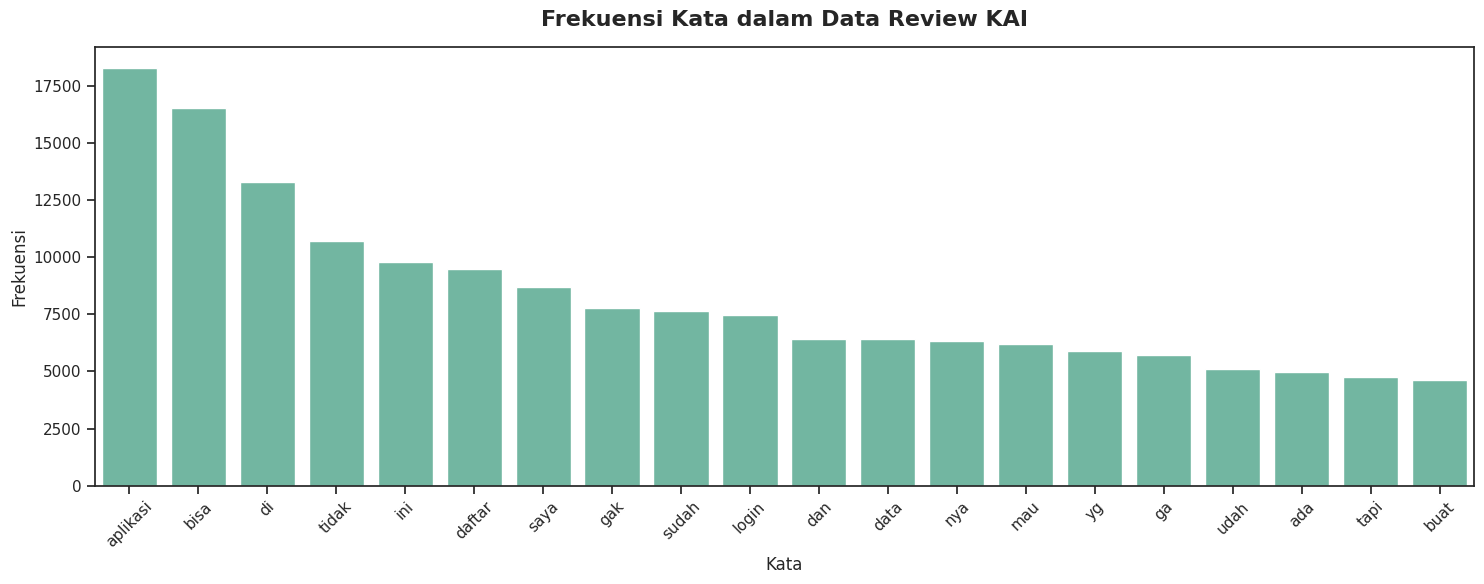

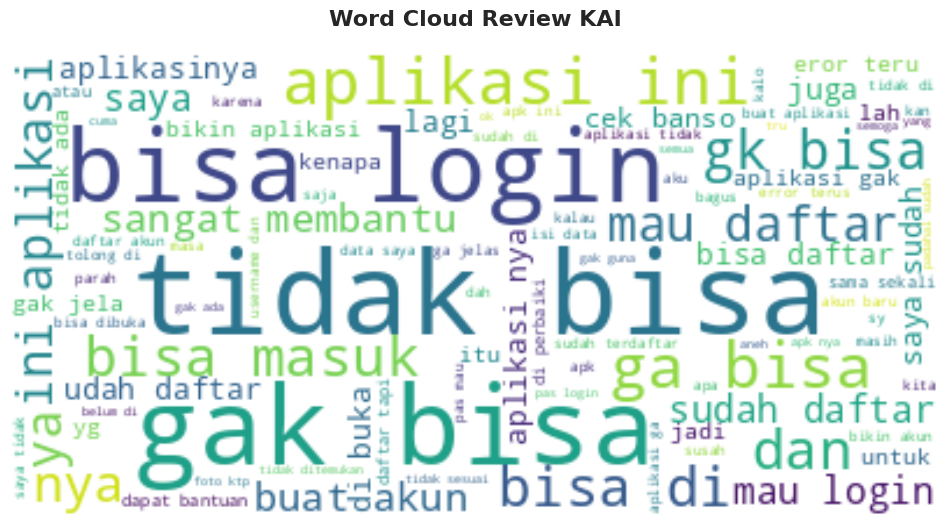

Visualisasi word frequency dan word cloud selesai


In [102]:
# ANALISIS CORPUS & WORD FREQUENCY
print("=== ANALISIS CORPUS ===")

def make_corpus(column):
    corpus_list = []
    for text in column:
        # pastikan text adalah string lalu split berdasarkan spasi (sudah dibersihkan sebelumnya)
        cleaned_list = str(text).split(' ')
        corpus_list.extend(cleaned_list)
    corpus = ' '.join(corpus_list)
    corpus = re.sub('[ ]+', ' ', corpus)
    return corpus

# Buat corpus
corpus = make_corpus(df_v2['review_text'])
corpus_set = set(corpus.split(' '))

print(f"Jumlah kata unik dalam corpus: {len(corpus_set)}")

# Hitung frekuensi kata (PERBAIKAN: gunakan tokenization sederhana tanpa NLTK)
def word_freq(corpus, top=20):
    # Tokenize sederhana: split berdasarkan spasi (karena teks sudah dibersihkan)
    tokenized_word = [t for t in corpus.split() if t.strip() != '']
    # FreqDist dari NLTK tidak butuh punkt; aman dipakai
    freqdist = FreqDist(tokenized_word)
    freqdist = freqdist.most_common(top)

    label = [tup[0] for tup in freqdist]
    freq = [tup[1] for tup in freqdist]
    df_freq = pd.DataFrame({'word': label, 'freq': freq})

    return df_freq

# Panggil fungsi sekali
corpus_freq = word_freq(corpus, top=20)
print(f"\nTop 20 kata paling sering:")
print(corpus_freq)

# Visualisasi frekuensi kata
plt.style.use('default')
sns.set(style='ticks', palette='Set2')
mpl.rcParams['axes.titlesize'] = 16
mpl.rcParams['axes.titlepad'] = 15

f, ax1 = plt.subplots(1, figsize=(15, 6))
sns.barplot(x='word', y='freq', data=corpus_freq, ax=ax1)
ax1.set_title('Frekuensi Kata dalam Data Review KAI', fontweight='bold')
ax1.set_xlabel('Kata', fontsize=12)
ax1.set_ylabel('Frekuensi', fontsize=12)
ax1.tick_params(axis='x', rotation=45)
plt.tight_layout()
plt.savefig('word_frequency_nb.png', dpi=300, bbox_inches='tight')
plt.show()

# WordCloud
# PERBAIKAN: pastikan corpus non-empty sebelum generate
if len(corpus.strip()) > 0:
    wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white",
                          colormap='viridis').generate(corpus)
    plt.figure(figsize=(12, 8))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.title('Word Cloud Review KAI', fontsize=16, fontweight='bold', pad=20)
    plt.savefig('word_cloud_nb.png', dpi=300, bbox_inches='tight')
    plt.show()
else:
    print("Corpus kosong — tidak ada WordCloud yang dibuat.")

print("Visualisasi word frequency dan word cloud selesai")


In [103]:
# SPLITTING DATA

print("SPLITTING DATA")

# Split data: 70% train, 15% validation, 15% test
train_set, temp_set = train_test_split(df_v2, test_size=0.3, stratify=df_v2['category'], random_state=42)
val_set, test_set = train_test_split(temp_set, test_size=0.5, stratify=temp_set['category'], random_state=42)

print(f"Train set shape: {train_set.shape}")
print(f"Validation set shape: {val_set.shape}")
print(f"Test set shape: {test_set.shape}")

print(f"\nDistribusi Train set:")
print(train_set['category'].value_counts())
print(f"\nDistribusi Validation set:")
print(val_set['category'].value_counts())
print(f"\nDistribusi Test set:")
print(test_set['category'].value_counts())
# Export ke CSV
train_set.to_csv('train_set_nb.csv', sep=',', index=False)
val_set.to_csv('val_set_nb.csv', sep=',', index=False)
test_set.to_csv('test_set_nb.csv', sep=',', index=False)

print("Dataset berhasil di-split dan disimpan")

SPLITTING DATA
Train set shape: (32036, 3)
Validation set shape: (6865, 3)
Test set shape: (6866, 3)

Distribusi Train set:
category
negative    25015
positive     7021
Name: count, dtype: int64

Distribusi Validation set:
category
negative    5361
positive    1504
Name: count, dtype: int64

Distribusi Test set:
category
negative    5361
positive    1505
Name: count, dtype: int64
Dataset berhasil di-split dan disimpan


In [104]:
# FEATURE EXTRACTION - TF-IDF

print("FEATURE EXTRACTION DENGAN TF-IDF")

# Inisialisasi TF-IDF Vectorizer
tfidf_vectorizer = TfidfVectorizer(
    max_features=5000,
    ngram_range=(1, 2),
    min_df=2,
    max_df=0.8
)

# Fit dan transform data training
X_train_tfidf = tfidf_vectorizer.fit_transform(train_set['review_text'])
X_val_tfidf = tfidf_vectorizer.transform(val_set['review_text'])
X_test_tfidf = tfidf_vectorizer.transform(test_set['review_text'])

y_train = train_set['category']
y_val = val_set['category']
y_test = test_set['category']

print(f"Shape X_train_tfidf: {X_train_tfidf.shape}")
print(f"Shape X_val_tfidf: {X_val_tfidf.shape}")
print(f"Shape X_test_tfidf: {X_test_tfidf.shape}")
print(f"\nJumlah fitur TF-IDF: {len(tfidf_vectorizer.get_feature_names_out())}")

FEATURE EXTRACTION DENGAN TF-IDF
Shape X_train_tfidf: (32036, 5000)
Shape X_val_tfidf: (6865, 5000)
Shape X_test_tfidf: (6866, 5000)

Jumlah fitur TF-IDF: 5000


In [105]:
# MODELING - NAIVE BAYES


print("TRAINING MODEL NAIVE BAYES")

# Inisialisasi model Multinomial Naive Bayes
nb_model = MultinomialNB(alpha=1.0)  # alpha untuk Laplace smoothing

# Training model
nb_model.fit(X_train_tfidf, y_train)

print("Model Naive Bayes berhasil di-training")


TRAINING MODEL NAIVE BAYES
Model Naive Bayes berhasil di-training


EVALUASI PADA VALIDATION SET

Validation Accuracy: 0.9043
Validation Precision: 0.8592
Validation Recall: 0.6735
Validation F1-Score: 0.7551

=== Classification Report - Validation Set ===
              precision    recall  f1-score   support

    negative       0.91      0.97      0.94      5361
    positive       0.86      0.67      0.76      1504

    accuracy                           0.90      6865
   macro avg       0.89      0.82      0.85      6865
weighted avg       0.90      0.90      0.90      6865



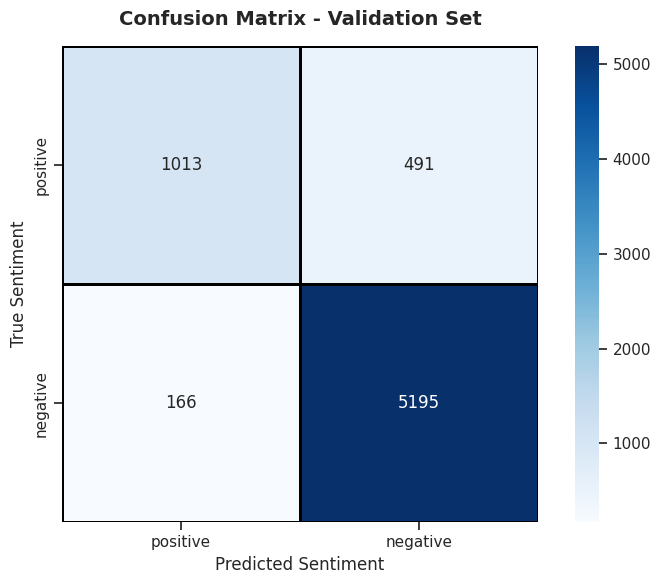

Hasil prediksi validation set disimpan


In [106]:
# 1EVALUASI MODEL - VALIDATION SET

print("EVALUASI PADA VALIDATION SET")

# Prediksi pada validation set
y_val_pred = nb_model.predict(X_val_tfidf)

# Hitung metrik
val_accuracy = accuracy_score(y_val, y_val_pred)
val_precision = precision_score(y_val, y_val_pred, pos_label='positive')
val_recall = recall_score(y_val, y_val_pred, pos_label='positive')
val_f1 = f1_score(y_val, y_val_pred, pos_label='positive')

print(f"\nValidation Accuracy: {val_accuracy:.4f}")
print(f"Validation Precision: {val_precision:.4f}")
print(f"Validation Recall: {val_recall:.4f}")
print(f"Validation F1-Score: {val_f1:.4f}")

# Classification report
print("\n=== Classification Report - Validation Set ===")
print(classification_report(y_val, y_val_pred, target_names=['negative', 'positive']))

# Confusion Matrix
cm_val = confusion_matrix(y_val, y_val_pred, labels=['positive', 'negative'])
df_cm_val = pd.DataFrame(cm_val, index=['positive', 'negative'], columns=['positive', 'negative'])

plt.figure(figsize=(8, 6))
sns.heatmap(df_cm_val, annot=True, fmt="d", cmap="Blues", cbar=True,
            square=True, linewidths=1, linecolor='black')
plt.ylabel('True Sentiment', fontsize=12)
plt.xlabel('Predicted Sentiment', fontsize=12)
plt.title('Confusion Matrix - Validation Set', fontsize=14, fontweight='bold', pad=15)
plt.tight_layout()
plt.savefig('confusion_matrix_val_nb.png', dpi=300, bbox_inches='tight')
plt.show()

# Simpan hasil prediksi validation
val_results = val_set.copy()
val_results['predicted'] = y_val_pred
val_results.to_csv('val_results_nb.csv', index=False)
print("Hasil prediksi validation set disimpan")


EVALUASI PADA TEST SET

Test Accuracy: 0.9040
Test Precision: 0.8567
Test Recall: 0.6751
Test F1-Score: 0.7551

=== Classification Report - Test Set ===
              precision    recall  f1-score   support

    negative       0.91      0.97      0.94      5361
    positive       0.86      0.68      0.76      1505

    accuracy                           0.90      6866
   macro avg       0.89      0.82      0.85      6866
weighted avg       0.90      0.90      0.90      6866



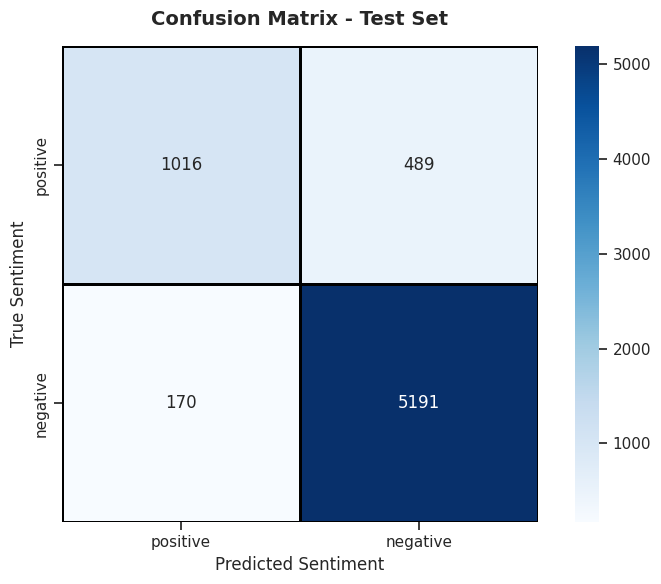

Hasil prediksi test set disimpan


In [107]:
# EVALUASI MODEL - TEST SET

print("EVALUASI PADA TEST SET")

# Prediksi pada test set
y_test_pred = nb_model.predict(X_test_tfidf)

# Hitung metrik
test_accuracy = accuracy_score(y_test, y_test_pred)
test_precision = precision_score(y_test, y_test_pred, pos_label='positive')
test_recall = recall_score(y_test, y_test_pred, pos_label='positive')
test_f1 = f1_score(y_test, y_test_pred, pos_label='positive')

print(f"\nTest Accuracy: {test_accuracy:.4f}")
print(f"Test Precision: {test_precision:.4f}")
print(f"Test Recall: {test_recall:.4f}")
print(f"Test F1-Score: {test_f1:.4f}")

# Classification report
print("\n=== Classification Report - Test Set ===")
print(classification_report(y_test, y_test_pred, target_names=['negative', 'positive']))

# Confusion Matrix
cm_test = confusion_matrix(y_test, y_test_pred, labels=['positive', 'negative'])
df_cm_test = pd.DataFrame(cm_test, index=['positive', 'negative'], columns=['positive', 'negative'])

plt.figure(figsize=(8, 6))
sns.heatmap(df_cm_test, annot=True, fmt="d", cmap="Blues", cbar=True,
            square=True, linewidths=1, linecolor='black')
plt.ylabel('True Sentiment', fontsize=12)
plt.xlabel('Predicted Sentiment', fontsize=12)
plt.title('Confusion Matrix - Test Set', fontsize=14, fontweight='bold', pad=15)
plt.tight_layout()
plt.savefig('confusion_matrix_test_nb.png', dpi=300, bbox_inches='tight')
plt.show()

# Simpan hasil prediksi test
test_results = test_set.copy()
test_results['predicted'] = y_test_pred
test_results.to_csv('test_results_nb.csv', index=False)
print("Hasil prediksi test set disimpan")


In [108]:
# UJI COBA MODEL DENGAN SAMPLE TEXT

print("UJI COBA MODEL DENGAN SAMPLE TEXT")

def predict_sentiment(text, model, vectorizer, stopwords, lexicon_map=None):
    # Preprocessing
    text_clean = clean_review(text)
    # apply lexicon & tokenization as pada pipeline
    text_clean = preprocess_v2(text_clean, stopwords, lexicon_map)

    # Transform dengan TF-IDF
    text_tfidf = vectorizer.transform([text_clean])

    # Prediksi
    prediction = model.predict(text_tfidf)[0]
    proba = model.predict_proba(text_tfidf)[0]

    # PERBAIKAN: jangan asumsikan index 1 = positive; cari index kelas 'positive'
    try:
        idx_positive = list(model.classes_).index('positive')
        idx_negative = list(model.classes_).index('negative')
    except ValueError:
        # fallback jika label beda urutan / nama
        idx_positive = 1 if len(model.classes_) > 1 else 0
        idx_negative = 0

    if prediction == 'positive':
        confidence = proba[idx_positive] * 100
    else:
        confidence = proba[idx_negative] * 100

    return prediction, confidence

# Test dengan beberapa contoh
sample_texts = [
    'aplikasi sangat bagus dan membantu',
    'aplikasi jelek tidak bisa login',
    'mantap sangat membantu sekali',
    'aplikasi error terus tidak bisa dipakai',
    'mudah digunakan dan praktis'
]

print("\nHasil prediksi sample text:")
print("-" * 80)
for text in sample_texts:
    pred, conf = predict_sentiment(text, nb_model, tfidf_vectorizer, stopwords_list, lex_map)
    print(f"Text: {text}")
    print(f"Prediction: {pred} (Confidence: {conf:.2f}%)")
    print("-" * 80)


UJI COBA MODEL DENGAN SAMPLE TEXT

Hasil prediksi sample text:
--------------------------------------------------------------------------------
Text: aplikasi sangat bagus dan membantu
Prediction: positive (Confidence: 95.06%)
--------------------------------------------------------------------------------
Text: aplikasi jelek tidak bisa login
Prediction: negative (Confidence: 98.79%)
--------------------------------------------------------------------------------
Text: mantap sangat membantu sekali
Prediction: positive (Confidence: 99.24%)
--------------------------------------------------------------------------------
Text: aplikasi error terus tidak bisa dipakai
Prediction: negative (Confidence: 96.96%)
--------------------------------------------------------------------------------
Text: mudah digunakan dan praktis
Prediction: positive (Confidence: 76.89%)
--------------------------------------------------------------------------------



Top 20 kata indikator POSITIVE:
  sangat membantu: 5.3480
  mantap: 5.3081
  sangat bermanfaat: 5.2652
  semoga bermanfaat: 4.8886
  ok: 4.6622
  top: 4.4672
  good: 4.4534
  alhamdulillah: 4.2979
  sangat bagus: 4.2530
  terimakasih kemensos: 4.1440
  sangat baik: 4.0849
  nice: 4.0262
  mantab: 3.9987
  semoga membantu: 3.9663
  sangat puas: 3.9512
  semoga bisa: 3.8733
  oke: 3.8715
  cukup membantu: 3.8224
  membantu sekali: 3.8125
  membantu dan: 3.7990

Top 20 kata indikator NEGATIVE:
  sampah: -3.3759
  aplikasi gak: -3.3350
  aplikasi sampah: -2.9647
  niat: -2.9332
  ga guna: -2.8786
  tidak berguna: -2.6935
  aplikasi ga: -2.6340
  gak jelas: -2.6270
  aplikasi gk: -2.5650
  buruk: -2.5530
  guna: -2.5519
  pembodohan: -2.5382
  ga jelas: -2.4919
  apaan: -2.4794
  daftar aja: -2.4598
  aplikasi apaan: -2.4529
  gabisa: -2.4371
  sekelas: -2.4277
  bikin aplikasi: -2.4192
  busuk: -2.3914


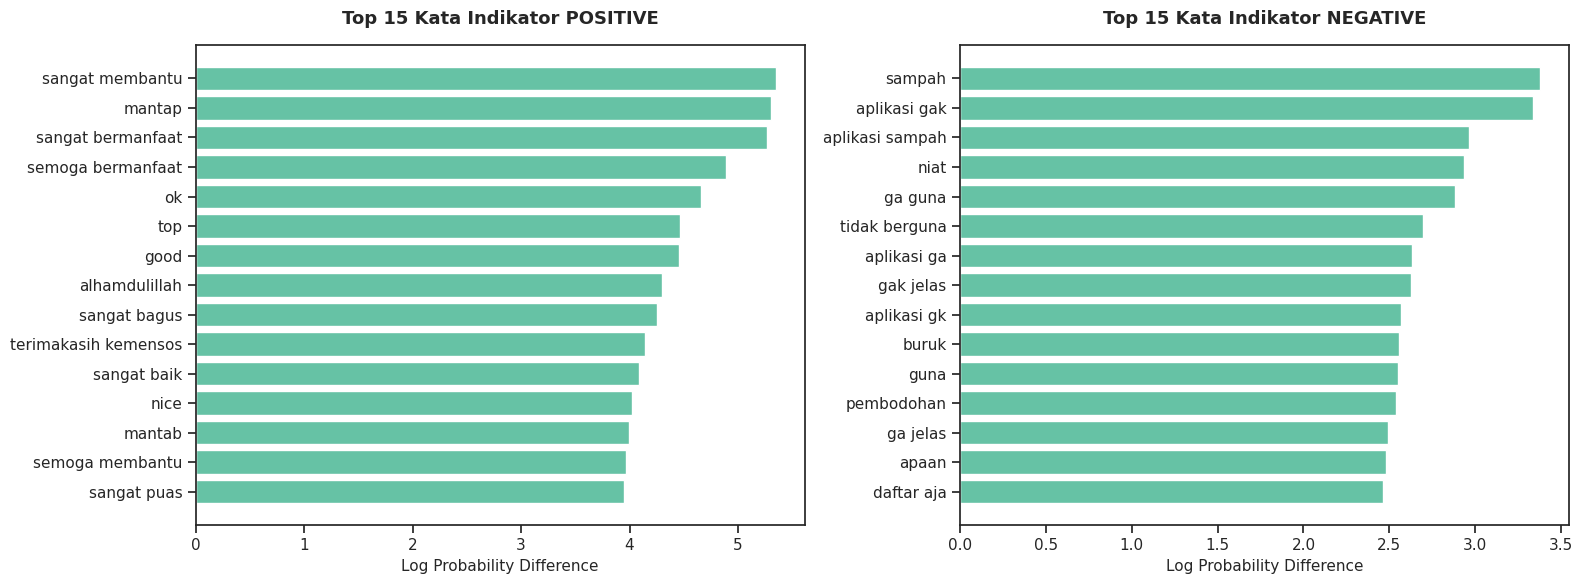

In [109]:
# ANALISIS FEATURE IMPORTANCE
# Ambil feature names
feature_names = tfidf_vectorizer.get_feature_names_out()

# Ambil log probability untuk setiap kelas
# PERINGATAN: urutan kelas sesuai nb_model.classes_
classes_order = list(nb_model.classes_)
if 'positive' in classes_order:
    idx_pos = classes_order.index('positive')
    idx_neg = classes_order.index('negative')
else:
    # fallback: asumsi posisi 1 & 0
    idx_pos = 1 if len(classes_order) > 1 else 0
    idx_neg = 0

log_prob_positive = nb_model.feature_log_prob_[idx_pos]
log_prob_negative = nb_model.feature_log_prob_[idx_neg]

# Hitung perbedaan log probability
log_prob_diff = log_prob_positive - log_prob_negative

# Ambil top 20 kata paling penting untuk positive
top_positive_indices = log_prob_diff.argsort()[-20:][::-1]
top_positive_words = [(feature_names[i], log_prob_diff[i]) for i in top_positive_indices]

# Ambil top 20 kata paling penting untuk negative
top_negative_indices = log_prob_diff.argsort()[:20]
top_negative_words = [(feature_names[i], log_prob_diff[i]) for i in top_negative_indices]

print("\nTop 20 kata indikator POSITIVE:")
for word, score in top_positive_words:
    print(f"  {word}: {score:.4f}")

print("\nTop 20 kata indikator NEGATIVE:")
for word, score in top_negative_words:
    print(f"  {word}: {score:.4f}")

# Visualisasi feature importance
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Positive words
pos_words = [w[0] for w in top_positive_words[:15]]
pos_scores = [w[1] for w in top_positive_words[:15]]
ax1.barh(range(len(pos_words)), pos_scores)
ax1.set_yticks(range(len(pos_words)))
ax1.set_yticklabels(pos_words)
ax1.set_xlabel('Log Probability Difference', fontsize=11)
ax1.set_title('Top 15 Kata Indikator POSITIVE', fontsize=13, fontweight='bold')
ax1.invert_yaxis()

# Negative words
neg_words = [w[0] for w in top_negative_words[:15]]
neg_scores = [abs(w[1]) for w in top_negative_words[:15]]
ax2.barh(range(len(neg_words)), neg_scores)
ax2.set_yticks(range(len(neg_words)))
ax2.set_yticklabels(neg_words)
ax2.set_xlabel('Log Probability Difference', fontsize=11)
ax2.set_title('Top 15 Kata Indikator NEGATIVE', fontsize=13, fontweight='bold')
ax2.invert_yaxis()

plt.tight_layout()
plt.savefig('feature_importance_nb.png', dpi=300, bbox_inches='tight')
plt.show()

In [110]:
# SUMMARY HASIL MODEL

print("SUMMARY HASIL MODEL NAIVE BAYES")
print("="*80)
print(f"\nJumlah Data:")
print(f"  - Training: {len(train_set)}")
print(f"  - Validation: {len(val_set)}")
print(f"  - Test: {len(test_set)}")
print(f"\nJumlah Fitur TF-IDF: {X_train_tfidf.shape[1]}")
print(f"\nPerforma Validation Set:")
print(f"  - Accuracy: {val_accuracy:.4f}")
print(f"  - Precision: {val_precision:.4f}")
print(f"  - Recall: {val_recall:.4f}")
print(f"  - F1-Score: {val_f1:.4f}")
print(f"\nPerforma Test Set:")
print(f"  - Accuracy: {test_accuracy:.4f}")
print(f"  - Precision: {test_precision:.4f}")
print(f"  - Recall: {test_recall:.4f}")
print(f"  - F1-Score: {test_f1:.4f}")
print("="*80)

print("\n✓ SELESAI - Model Naive Bayes berhasil dibuat dan dievaluasi!")
print("\nFile yang dihasilkan:")
print("  1. df_v1_nb.csv - Hasil preprocessing tahap 1")
print("  2. df_v2_nb.csv - Hasil preprocessing tahap 2")
print("  3. train_set_nb.csv - Training set")
print("  4. val_set_nb.csv - Validation set")
print("  5. test_set_nb.csv - Test set")
print("  6. val_results_nb.csv - Hasil prediksi validation")
print("  7. test_results_nb.csv - Hasil prediksi test")
print("  8. sentiment_distribution_nb.png - Visualisasi proporsi sentimen")
print("  9. word_frequency_nb.png - Visualisasi frekuensi kata")
print("  10. word_cloud_nb.png - Word cloud")
print("  11. confusion_matrix_val_nb.png - Confusion matrix validation")
print("  12. confusion_matrix_test_nb.png - Confusion matrix test")
print("  13. feature_importance_nb.png - Feature importance")

SUMMARY HASIL MODEL NAIVE BAYES

Jumlah Data:
  - Training: 32036
  - Validation: 6865
  - Test: 6866

Jumlah Fitur TF-IDF: 5000

Performa Validation Set:
  - Accuracy: 0.9043
  - Precision: 0.8592
  - Recall: 0.6735
  - F1-Score: 0.7551

Performa Test Set:
  - Accuracy: 0.9040
  - Precision: 0.8567
  - Recall: 0.6751
  - F1-Score: 0.7551

✓ SELESAI - Model Naive Bayes berhasil dibuat dan dievaluasi!

File yang dihasilkan:
  1. df_v1_nb.csv - Hasil preprocessing tahap 1
  2. df_v2_nb.csv - Hasil preprocessing tahap 2
  3. train_set_nb.csv - Training set
  4. val_set_nb.csv - Validation set
  5. test_set_nb.csv - Test set
  6. val_results_nb.csv - Hasil prediksi validation
  7. test_results_nb.csv - Hasil prediksi test
  8. sentiment_distribution_nb.png - Visualisasi proporsi sentimen
  9. word_frequency_nb.png - Visualisasi frekuensi kata
  10. word_cloud_nb.png - Word cloud
  11. confusion_matrix_val_nb.png - Confusion matrix validation
  12. confusion_matrix_test_nb.png - Confusion m